In [2]:
"""
===================================================================================
K-MEANS CLUSTERING - MACHINE LEARNING CUSTOMER SEGMENTATION
===================================================================================
Project: Customer Segmentation using K-Means Clustering
Author: Mausami Narayan
Date: February 2026
Algorithm: K-Means Unsupervised Machine Learning
===================================================================================
"""

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("=" * 80)
print("K-MEANS CLUSTERING - MACHINE LEARNING")
print("=" * 80)
print(" Standard libraries loaded!")
print(" Machine Learning libraries loaded!")
print("""
NEW LIBRARIES EXPLAINED:
   StandardScaler → Scales all features to same range
                    (so no single feature dominates)
   
   KMeans         → The clustering algorithm
                    Groups similar customers together
   
   PCA            → Reduces dimensions for visualization
                    (converts many columns to just 2)
   
   silhouette_score → Measures how good our clusters are
                      (score closer to 1 = better clusters)
""")

K-MEANS CLUSTERING - MACHINE LEARNING
 Standard libraries loaded!
 Machine Learning libraries loaded!

NEW LIBRARIES EXPLAINED:
   StandardScaler → Scales all features to same range
                    (so no single feature dominates)
   
   KMeans         → The clustering algorithm
                    Groups similar customers together
   
   PCA            → Reduces dimensions for visualization
                    (converts many columns to just 2)
   
   silhouette_score → Measures how good our clusters are
                      (score closer to 1 = better clusters)



In [4]:
print("-" * 80)
print("LOADING RFM DATA")
print("-" * 80)

# Load our RFM analysis results
rfm = pd.read_csv('outputs/rfm_analysis.csv')

print(f"RFM data loaded!")
print(f"Customers: {len(rfm):,}")
print(f"\nFirst 5 rows:")
print(rfm[['CustomerID', 'Recency', 
           'Frequency', 'Monetary']].head())

print("""
   WHY USE RFM DATA FOR K-MEANS?
   K-Means needs numerical data.
   Our RFM values (Recency, Frequency, Monetary)
   are perfect numerical features that describe
   customer behavior!
""")

--------------------------------------------------------------------------------
LOADING RFM DATA
--------------------------------------------------------------------------------
RFM data loaded!
Customers: 4,338

First 5 rows:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40

   WHY USE RFM DATA FOR K-MEANS?
   K-Means needs numerical data.
   Our RFM values (Recency, Frequency, Monetary)
   are perfect numerical features that describe
   customer behavior!



In [6]:
print("-" * 80)
print("STEP 1: PREPARE FEATURES FOR MACHINE LEARNING")
print("-" * 80)

# Select only RFM columns for clustering
# These are our FEATURES (what K-Means will learn from)
features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

print("Features selected for clustering:")
print(features.describe().round(2))

print("""
   PROBLEM WITH RAW DATA:
   Look at the ranges:
   - Recency:   0 to 373 days
   - Frequency: 1 to 200+ orders  
   - Monetary:  £0 to £77,183

   These are VERY different scales!
   K-Means uses DISTANCE to group customers.
   
   If we don't scale, Monetary will DOMINATE
   because its numbers are much bigger!
   
   Solution: StandardScaler!
""")

--------------------------------------------------------------------------------
STEP 1: PREPARE FEATURES FOR MACHINE LEARNING
--------------------------------------------------------------------------------
Features selected for clustering:
       Recency  Frequency   Monetary
count  4338.00    4338.00    4338.00
mean     92.54       4.27    2048.69
std     100.01       7.70    8985.23
min       1.00       1.00       3.75
25%      18.00       1.00     306.48
50%      51.00       2.00     668.57
75%     142.00       5.00    1660.60
max     374.00     209.00  280206.02

   PROBLEM WITH RAW DATA:
   Look at the ranges:
   - Recency:   0 to 373 days
   - Frequency: 1 to 200+ orders  
   - Monetary:  £0 to £77,183

   These are VERY different scales!
   K-Means uses DISTANCE to group customers.
   
   If we don't scale, Monetary will DOMINATE
   because its numbers are much bigger!
   
   Solution: StandardScaler!



In [8]:
print("-" * 80)
print("STEP 2: SCALE THE FEATURES")
print("-" * 80)

# Create scaler
scaler = StandardScaler()

# Scale the features
# This transforms each feature to have mean=0, std=1
rfm_scaled = scaler.fit_transform(features)

# Convert back to dataframe for easy viewing
rfm_scaled_df = pd.DataFrame(rfm_scaled, 
                              columns=['Recency', 
                                       'Frequency', 
                                       'Monetary'])

print("BEFORE scaling:")
print(f"Recency   - Min: {features['Recency'].min():.1f}, Max: {features['Recency'].max():.1f}")
print(f"Frequency - Min: {features['Frequency'].min():.1f}, Max: {features['Frequency'].max():.1f}")
print(f"Monetary  - Min: {features['Monetary'].min():.1f}, Max: {features['Monetary'].max():.1f}")

print("\nAFTER scaling (all on same scale):")
print(f"Recency   - Min: {rfm_scaled_df['Recency'].min():.2f}, Max: {rfm_scaled_df['Recency'].max():.2f}")
print(f"Frequency - Min: {rfm_scaled_df['Frequency'].min():.2f}, Max: {rfm_scaled_df['Frequency'].max():.2f}")
print(f"Monetary  - Min: {rfm_scaled_df['Monetary'].min():.2f}, Max: {rfm_scaled_df['Monetary'].max():.2f}")

print("\nAll features now on same scale!")
print("K-Means can now treat all features equally!")

--------------------------------------------------------------------------------
STEP 2: SCALE THE FEATURES
--------------------------------------------------------------------------------
BEFORE scaling:
Recency   - Min: 1.0, Max: 374.0
Frequency - Min: 1.0, Max: 209.0
Monetary  - Min: 3.8, Max: 280206.0

AFTER scaling (all on same scale):
Recency   - Min: -0.92, Max: 2.81
Frequency - Min: -0.43, Max: 26.60
Monetary  - Min: -0.23, Max: 30.96

All features now on same scale!
K-Means can now treat all features equally!


In [12]:
print("-" * 80)
print("STEP 3: FIND OPTIMAL NUMBER OF CLUSTERS")
print("       (Using Elbow Method)")
print("-" * 80)

print("""
   HOW MANY CLUSTERS SHOULD WE USE?
   We don't know yet! 
   The Elbow Method helps us find out.
   
   We'll try K = 2, 3, 4, 5, 6, 7, 8, 9, 10
   and measure how good each K is.
   
   We look for the "elbow" in the graph
   where adding more clusters stops helping much.
""")

# Calculate inertia (within-cluster sum of squares)
# Lower inertia = clusters are more tight/compact
inertia = []
silhouette_scores = []
K_range = range(2, 11)

print("Testing different numbers of clusters...")
print("-" * 80)

for k in K_range:
    # Create and fit K-Means model
    kmeans = KMeans(n_clusters=k, 
                    random_state=42, 
                    n_init=10)
    kmeans.fit(rfm_scaled)
    
    # Store inertia
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    score = silhouette_score(rfm_scaled, 
                             kmeans.labels_)
    silhouette_scores.append(score)
    
    print(f"K={k}: Inertia={kmeans.inertia_:,.0f} | Silhouette Score={score:.3f}")

print("\nTesting complete!")
print("\nHigher Silhouette Score = Better clusters")
print(f"Best K by Silhouette: {K_range[silhouette_scores.index(max(silhouette_scores))]}")

--------------------------------------------------------------------------------
STEP 3: FIND OPTIMAL NUMBER OF CLUSTERS
       (Using Elbow Method)
--------------------------------------------------------------------------------

   HOW MANY CLUSTERS SHOULD WE USE?
   We don't know yet! 
   The Elbow Method helps us find out.
   
   We'll try K = 2, 3, 4, 5, 6, 7, 8, 9, 10
   and measure how good each K is.
   
   We look for the "elbow" in the graph
   where adding more clusters stops helping much.

Testing different numbers of clusters...
--------------------------------------------------------------------------------
K=2: Inertia=9,015 | Silhouette Score=0.896
K=3: Inertia=5,441 | Silhouette Score=0.594
K=4: Inertia=4,096 | Silhouette Score=0.616
K=5: Inertia=3,120 | Silhouette Score=0.617
K=6: Inertia=2,474 | Silhouette Score=0.598
K=7: Inertia=2,024 | Silhouette Score=0.517
K=8: Inertia=1,717 | Silhouette Score=0.486
K=9: Inertia=1,469 | Silhouette Score=0.478
K=10: Inertia=1,281

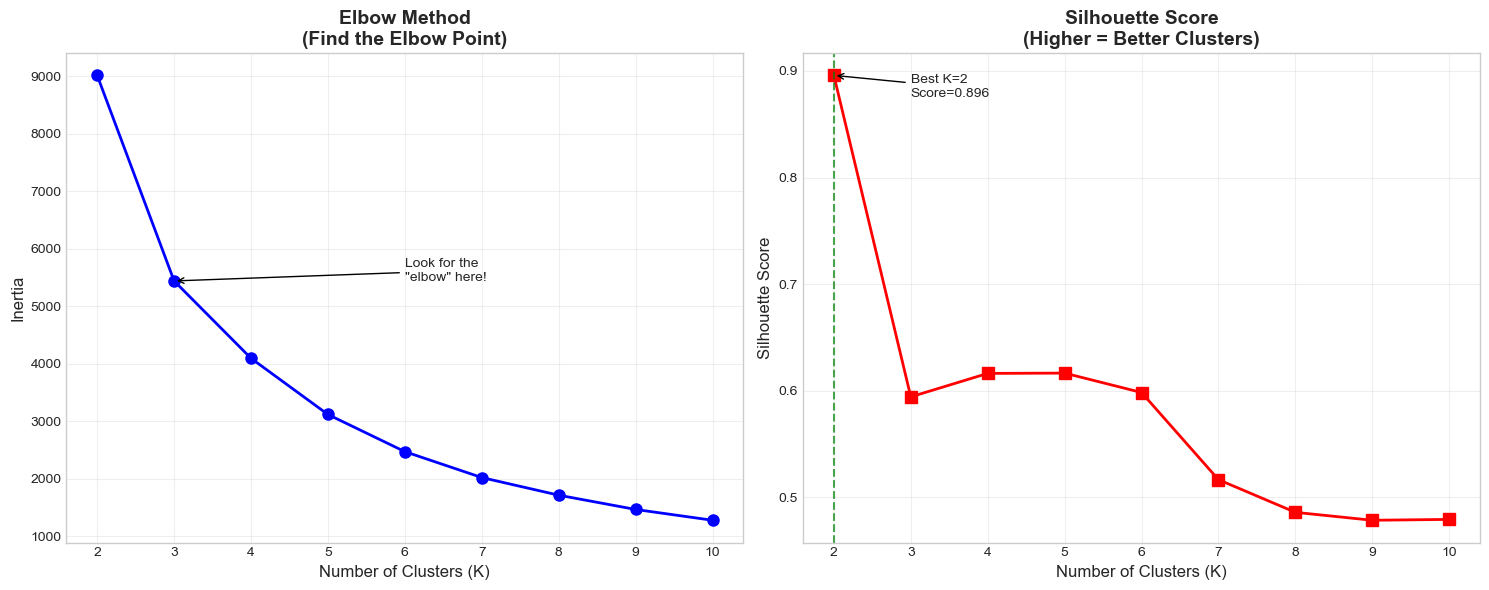

Saved: visualizations/04_elbow_method.png

Optimal number of clusters: 2


In [14]:
# Plot Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Elbow Method
axes[0].plot(list(K_range), inertia, 
             'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method\n(Find the Elbow Point)', 
                   fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Add annotation
axes[0].annotate('Look for the\n"elbow" here!', 
                  xy=(3, inertia[1]), 
                  xytext=(6, inertia[1]),
                  fontsize=10,
                  arrowprops=dict(arrowstyle='->'))

# Chart 2: Silhouette Scores
axes[1].plot(list(K_range), silhouette_scores, 
             'rs-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score\n(Higher = Better Clusters)', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Mark best score
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
axes[1].axvline(x=best_k, color='green', 
                linestyle='--', alpha=0.7)
axes[1].annotate(f'Best K={best_k}\nScore={best_score:.3f}',
                  xy=(best_k, best_score),
                  xytext=(best_k+1, best_score-0.02),
                  fontsize=10,
                  arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.savefig('visualizations/04_elbow_method.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: visualizations/04_elbow_method.png")
print(f"\nOptimal number of clusters: {best_k}")

In [18]:
print("-" * 80)
print("STEP 4: APPLY K-MEANS CLUSTERING")
print("=" * 80)

# Use optimal K
optimal_k = best_k

print(f"Using K = {optimal_k} clusters")
print("-" * 80)

# Create and train final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k,
                      random_state=42,
                      n_init=10)

# Fit the model and get cluster labels
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)

print(f"K-Means clustering complete!")
print(f"\nCustomers per cluster:")
print(rfm['Cluster'].value_counts().sort_index())

print("""
   WHAT JUST HAPPENED?
   K-Means looked at every customer's
   Recency, Frequency, and Monetary values
   and grouped SIMILAR customers together!
   
   Each customer now has a Cluster number (0, 1, 2...)
   Customers in the same cluster behave similarly!
""")

--------------------------------------------------------------------------------
STEP 4: APPLY K-MEANS CLUSTERING
Using K = 2 clusters
--------------------------------------------------------------------------------
K-Means clustering complete!

Customers per cluster:
Cluster
0    4312
1      26
Name: count, dtype: int64

   WHAT JUST HAPPENED?
   K-Means looked at every customer's
   Recency, Frequency, and Monetary values
   and grouped SIMILAR customers together!
   
   Each customer now has a Cluster number (0, 1, 2...)
   Customers in the same cluster behave similarly!



In [22]:
print("-" * 80)
print("STEP 5: ANALYZE EACH CLUSTER")
print("-" * 80)

# Calculate average RFM values per cluster
cluster_analysis = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

cluster_analysis.columns = ['Count', 
                             'Avg_Recency',
                             'Avg_Frequency', 
                             'Avg_Monetary']

cluster_analysis = cluster_analysis.sort_values('Avg_Monetary', 
                                                  ascending=False)

print(cluster_analysis.to_string())

# Label clusters based on their characteristics
print("\n" + "-" * 80)
print("CLUSTER INTERPRETATION:")
print("-" * 80)

for cluster in cluster_analysis.index:
    row = cluster_analysis.loc[cluster]
    recency = row['Avg_Recency']
    frequency = row['Avg_Frequency']
    monetary = row['Avg_Monetary']
    count = int(row['Count'])
    
    # Determine cluster type
    if monetary > rfm['Monetary'].mean() * 1.5:
        if recency < rfm['Recency'].mean():
            label = "HIGH VALUE - ACTIVE"
        else:
            label = "HIGH VALUE - AT RISK"
    elif frequency > rfm['Frequency'].mean() * 1.5:
        label = "FREQUENT BUYERS"
    elif recency < rfm['Recency'].mean() * 0.5:
        label = "RECENT CUSTOMERS"
    elif recency > rfm['Recency'].mean() * 1.5:
        label = "INACTIVE CUSTOMERS"
    else:
        label = "AVERAGE CUSTOMERS"

    print(f"\nCluster {cluster}: {label}")
    print(f"   Customers:  {count:,}")
    print(f"   Recency:    {recency:.0f} days ago")
    print(f"   Frequency:  {frequency:.1f} orders")
    print(f"   Avg Spend:  £{monetary:,.2f}")

--------------------------------------------------------------------------------
STEP 5: ANALYZE EACH CLUSTER
--------------------------------------------------------------------------------
         Count  Avg_Recency  Avg_Frequency  Avg_Monetary
Cluster                                                 
1           26         6.04          66.42      85826.08
0         4312        93.06           3.90       1543.54

--------------------------------------------------------------------------------
CLUSTER INTERPRETATION:
--------------------------------------------------------------------------------

Cluster 1: HIGH VALUE - ACTIVE
   Customers:  26
   Recency:    6 days ago
   Frequency:  66.4 orders
   Avg Spend:  £85,826.08

Cluster 0: AVERAGE CUSTOMERS
   Customers:  4,312
   Recency:    93 days ago
   Frequency:  3.9 orders
   Avg Spend:  £1,543.54


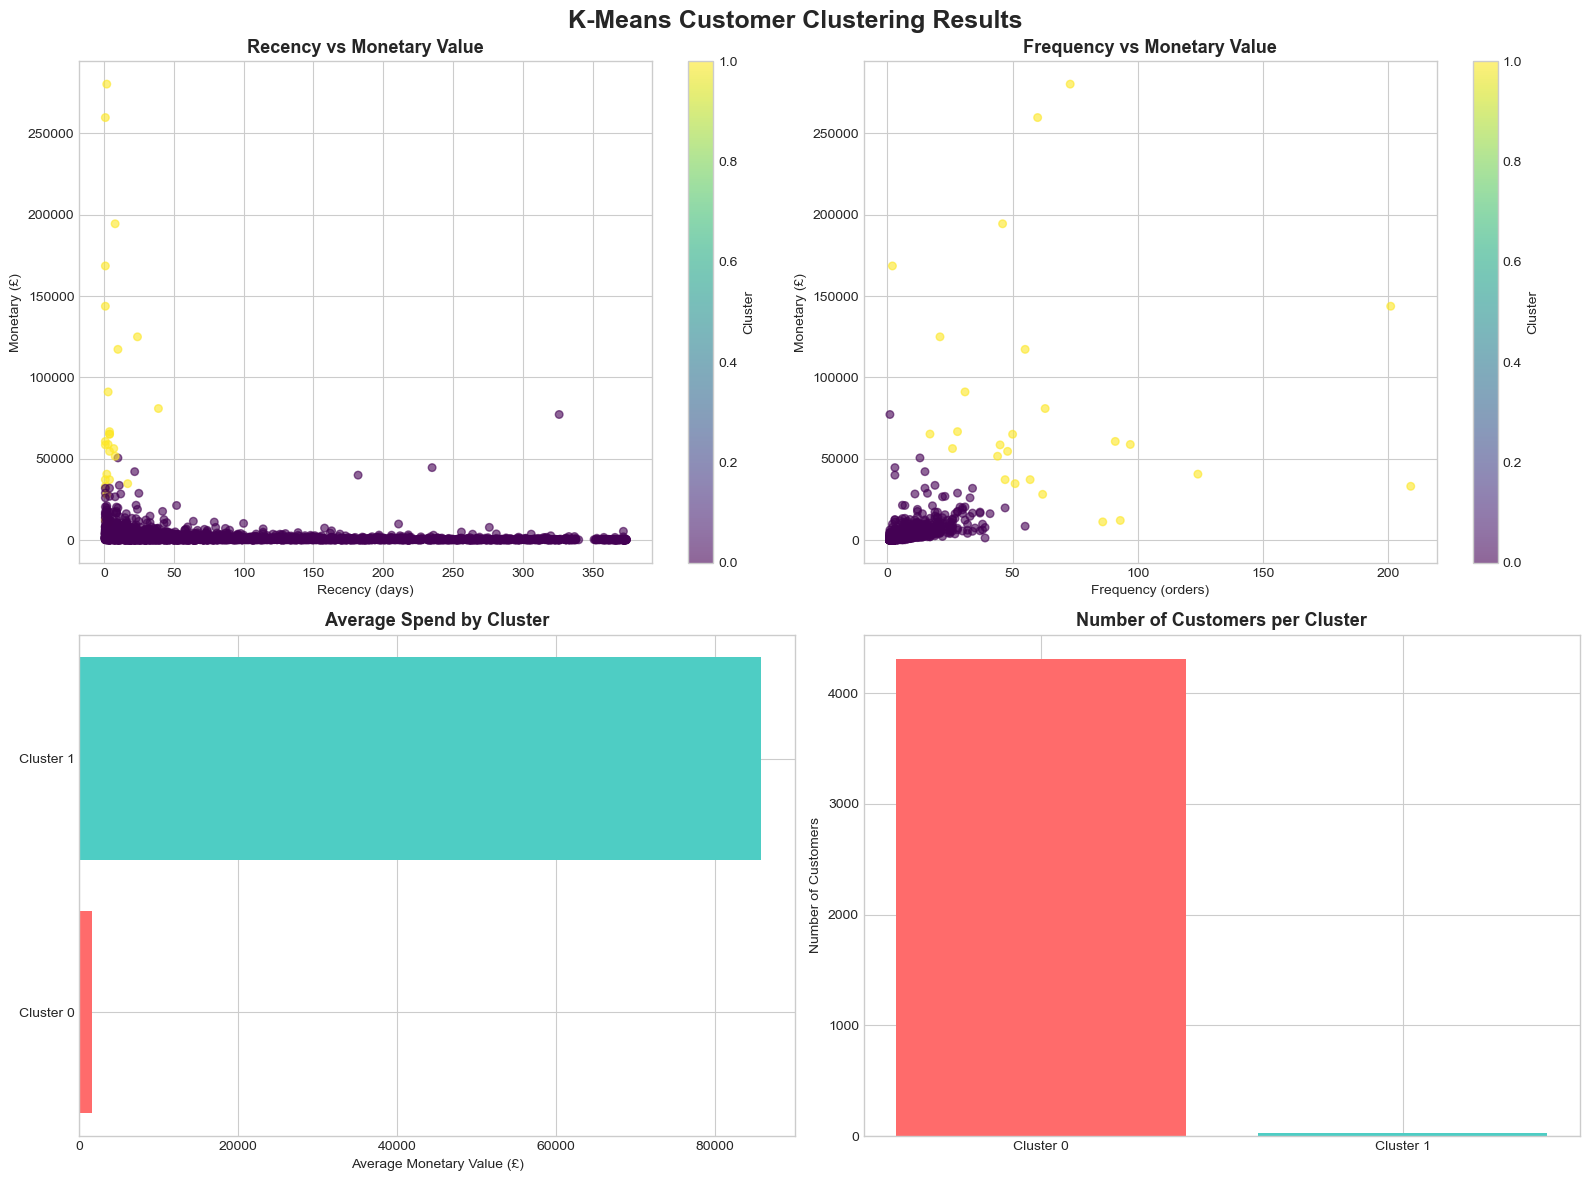

Saved: visualizations/05_kmeans_clusters.png


In [24]:
# Create cluster visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('K-Means Customer Clustering Results', 
             fontsize=18, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', 
          '#96CEB4', '#FFEAA7', '#DDA0DD']
cluster_colors = [colors[i] for i in rfm['Cluster']]

# Chart 1: Recency vs Monetary
scatter1 = axes[0,0].scatter(rfm['Recency'], 
                              rfm['Monetary'],
                              c=rfm['Cluster'],
                              cmap='viridis',
                              alpha=0.6, s=30)
axes[0,0].set_title('Recency vs Monetary Value', 
                     fontsize=13, fontweight='bold')
axes[0,0].set_xlabel('Recency (days)')
axes[0,0].set_ylabel('Monetary (£)')
plt.colorbar(scatter1, ax=axes[0,0], label='Cluster')

# Chart 2: Frequency vs Monetary
scatter2 = axes[0,1].scatter(rfm['Frequency'], 
                              rfm['Monetary'],
                              c=rfm['Cluster'],
                              cmap='viridis',
                              alpha=0.6, s=30)
axes[0,1].set_title('Frequency vs Monetary Value', 
                     fontsize=13, fontweight='bold')
axes[0,1].set_xlabel('Frequency (orders)')
axes[0,1].set_ylabel('Monetary (£)')
plt.colorbar(scatter2, ax=axes[0,1], label='Cluster')

# Chart 3: Average spend per cluster
cluster_spend = rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=True)
axes[1,0].barh(range(len(cluster_spend)), 
               cluster_spend.values,
               color=[colors[i] for i in cluster_spend.index])
axes[1,0].set_yticks(range(len(cluster_spend)))
axes[1,0].set_yticklabels([f'Cluster {i}' for i in cluster_spend.index])
axes[1,0].set_title('Average Spend by Cluster', 
                     fontsize=13, fontweight='bold')
axes[1,0].set_xlabel('Average Monetary Value (£)')

# Chart 4: Customer count per cluster
cluster_count = rfm['Cluster'].value_counts().sort_index()
axes[1,1].bar(range(len(cluster_count)), 
              cluster_count.values,
              color=[colors[i] for i in cluster_count.index])
axes[1,1].set_xticks(range(len(cluster_count)))
axes[1,1].set_xticklabels([f'Cluster {i}' for i in cluster_count.index])
axes[1,1].set_title('Number of Customers per Cluster', 
                     fontsize=13, fontweight='bold')
axes[1,1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('visualizations/05_kmeans_clusters.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/05_kmeans_clusters.png")

--------------------------------------------------------------------------------
STEP 6: PCA VISUALIZATION
--------------------------------------------------------------------------------

   WHAT IS PCA?
   We have 3 dimensions (R, F, M).
   We can't easily visualize 3D data.
   
   PCA (Principal Component Analysis) 
   COMPRESSES 3 dimensions into 2
   while keeping the important patterns!
   
   This lets us plot our clusters in 2D!

PCA complete!
Variance explained by 2 components: 85.7%


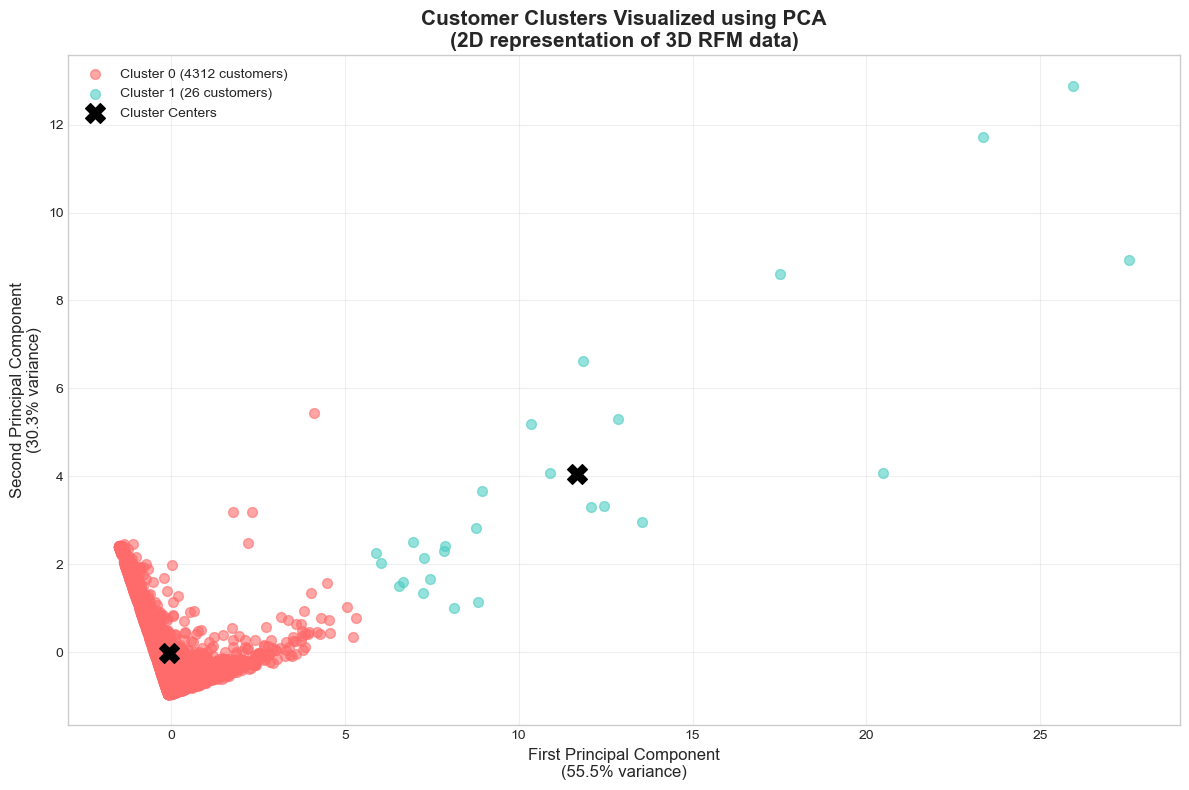

Saved: visualizations/06_pca_clusters.png


In [28]:
print("-" * 80)
print("STEP 6: PCA VISUALIZATION")
print("-" * 80)

print("""
   WHAT IS PCA?
   We have 3 dimensions (R, F, M).
   We can't easily visualize 3D data.
   
   PCA (Principal Component Analysis) 
   COMPRESSES 3 dimensions into 2
   while keeping the important patterns!
   
   This lets us plot our clusters in 2D!
""")

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled)

print(f"PCA complete!")
print(f"Variance explained by 2 components: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Create PCA visualization
plt.figure(figsize=(12, 8))

colors_pca = ['#FF6B6B', '#4ECDC4', '#45B7D1', 
              '#96CEB4', '#FFEAA7', '#DDA0DD']

for cluster in range(optimal_k):
    mask = rfm['Cluster'] == cluster
    plt.scatter(rfm_pca[mask, 0], 
                rfm_pca[mask, 1],
                c=colors_pca[cluster],
                label=f'Cluster {cluster} ({mask.sum()} customers)',
                alpha=0.6, s=50)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], 
            centers_pca[:, 1],
            c='black', marker='X', s=200,
            zorder=5, label='Cluster Centers')

plt.title('Customer Clusters Visualized using PCA\n(2D representation of 3D RFM data)',
          fontsize=15, fontweight='bold')
plt.xlabel(f'First Principal Component\n({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
           fontsize=12)
plt.ylabel(f'Second Principal Component\n({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
           fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/06_pca_clusters.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/06_pca_clusters.png")

In [32]:
# Save complete results
rfm.to_csv('outputs/final_customer_segments.csv', index=False)

print("-" * 80)
print("K-MEANS CLUSTERING COMPLETE!")
print("-" * 80)
print(f"""
FINAL PROJECT SUMMARY:
{'-'*60}
Dataset:     UCI Online Retail (UK Gift Shop)
Period:      December 2010 - December 2011
Transactions: 392,692 (after cleaning)
Customers:   4,338 unique customers
Revenue:     £8,887,208.89

ANALYSIS PERFORMED:
1. Data Exploration & Cleaning
2. RFM Analysis (9 customer segments)
3. K-Means ML Clustering ({optimal_k} clusters)
4. PCA Visualization

SKILLS DEMONSTRATED:
- Python (pandas, numpy, matplotlib, seaborn)
- Machine Learning (scikit-learn)
- K-Means Clustering
- Feature Scaling (StandardScaler)
- Dimensionality Reduction (PCA)
- Elbow Method & Silhouette Score
- Data Visualization
- Business Intelligence
- Customer Segmentation
- RFM Analysis

FILES SAVED:
- outputs/cleaned_retail_data.csv
- outputs/rfm_analysis.csv
- outputs/final_customer_segments.csv
- visualizations/01_top_countries.png
- visualizations/02_sales_patterns.png
- visualizations/03_rfm_segments.png
- visualizations/04_elbow_method.png
- visualizations/05_kmeans_clusters.png
- visualizations/06_pca_clusters.png
{'-'*60}
""")

--------------------------------------------------------------------------------
K-MEANS CLUSTERING COMPLETE!
--------------------------------------------------------------------------------

FINAL PROJECT SUMMARY:
------------------------------------------------------------
Dataset:     UCI Online Retail (UK Gift Shop)
Period:      December 2010 - December 2011
Transactions: 392,692 (after cleaning)
Customers:   4,338 unique customers
Revenue:     £8,887,208.89

ANALYSIS PERFORMED:
1. Data Exploration & Cleaning
2. RFM Analysis (9 customer segments)
3. K-Means ML Clustering (2 clusters)
4. PCA Visualization

SKILLS DEMONSTRATED:
- Python (pandas, numpy, matplotlib, seaborn)
- Machine Learning (scikit-learn)
- K-Means Clustering
- Feature Scaling (StandardScaler)
- Dimensionality Reduction (PCA)
- Elbow Method & Silhouette Score
- Data Visualization
- Business Intelligence
- Customer Segmentation
- RFM Analysis

FILES SAVED:
- outputs/cleaned_retail_data.csv
- outputs/rfm_analysis.csv
